In [126]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 

import seaborn as sns

In [251]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}


with open('mushroom_train.pkl', 'rb') as f:
    data = pickle.load(f)
    y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    X = np.array([data[i]["images"].numpy() for i in range(len(data))])

with open('mushroom_test.pkl', 'rb') as f:
    data = pickle.load(f)
    ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

## Specify learning algorithms

In [4]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [5]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=2,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # Used in polyak-becpi
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # multiplier to control sampling probability in bec-absloss
    prob_const = 1,
    # debug
    verbose=True,
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        #thetas[i] = theta
        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak-rand":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)

            grad *= zeta
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = np.clip(prob_const * pz, a_min=0, a_max=1)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [199]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [200]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [201]:
# When minimizing train loss
hyperparam_per_algo

{'absloss': {'eta': 4.468088707739409, 'lam': 0.002481616850480029},
 'polyak_absloss': {'eta': 4.461855128971945,
  'kappa': 1.6673346621825877,
  'kappa0': 0.9021854949403395,
  'lam': 0.0024810093752773168,
  'omega': 1.0000781428405208},
 'polyak_exponent': {'eta': 3.8244649039763874,
  'kappa': 1.66394548495515,
  'kappa0': 0.9028972731286501,
  'lam': 0.002514787546680623},
 'random': {'eta': 4.170428165141693, 'lam': 0.002482399527384627}}

In [75]:
# When minimizing train loss
hyperparam_per_algo

{'absloss': {'eta': 4.475057560070625, 'lam': 0.0025005449961486887},
 'polyak_absloss': {'eta': 4.461855128971945,
  'kappa': 1.6673346621825877,
  'kappa0': 0.9021854949403395,
  'lam': 0.0024810093752773168,
  'omega': 1.0000781428405208},
 'polyak_exponent': {'eta': 3.8244649039763874,
  'kappa': 1.66394548495515,
  'kappa0': 0.9028972731286501,
  'lam': 0.002514787546680623},
 'random': {'eta': 4.348417128328877, 'lam': 0.0025692910109843176}}

In [76]:
# When minimizing model_loss
hyperparam_per_algo

{'absloss': {'eta': 4.475057560070625, 'lam': 0.0025005449961486887},
 'polyak_absloss': {'eta': 4.461855128971945,
  'kappa': 1.6673346621825877,
  'kappa0': 0.9021854949403395,
  'lam': 0.0024810093752773168,
  'omega': 1.0000781428405208},
 'polyak_exponent': {'eta': 3.8244649039763874,
  'kappa': 1.66394548495515,
  'kappa0': 0.9028972731286501,
  'lam': 0.002514787546680623},
 'random': {'eta': 4.348417128328877, 'lam': 0.0025692910109843176}}

In [77]:
# When minimising loss
hyperparam_per_algo

{'absloss': {'eta': 4.475057560070625, 'lam': 0.0025005449961486887},
 'polyak_absloss': {'eta': 4.461855128971945,
  'kappa': 1.6673346621825877,
  'kappa0': 0.9021854949403395,
  'lam': 0.0024810093752773168,
  'omega': 1.0000781428405208},
 'polyak_exponent': {'eta': 3.8244649039763874,
  'kappa': 1.66394548495515,
  'kappa0': 0.9028972731286501,
  'lam': 0.002514787546680623},
 'random': {'eta': 4.348417128328877, 'lam': 0.0025692910109843176}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [78]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **absloss_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6901587580175323, train loss: 0.6909523837576914, ||theta||_1: 214.67915150175153
loss: 0.6888570448492478, train loss: 0.6921022338764611, ||theta||_1: 321.3620212638669
loss: 0.6880057688238278, train loss: 0.6615039865993416, ||theta||_1: 380.3134292997128
loss: 0.6876539245448078, train loss: 0.6745008878524427, ||theta||_1: 416.2769351536381
loss: 0.6871775929547447, train loss: 0.6910647724101773, ||theta||_1: 438.37228627184675
loss: 0.6870934422087851, train loss: 0.6908567893793947, ||theta||_1: 449.79116130427485
loss: 0.6871755514339863, train loss: 0.6804438031190451, ||theta||_1: 457.0235002967224
loss: 0.6869350677769135, train loss: 0.6896519966314246, ||theta||_1: 460.8288498547172
loss: 0.686822846957547, train loss: 0.6885133848671827, ||theta||_1: 461.8989391757127
loss: 0.6869857228622899, train loss: 0.6481107961472612, ||t

In [79]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [80]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6905359623246835, train loss: 0.6913050077609779, ||theta||_1: 194.66920017086488
loss: 0.6890184824343308, train loss: 0.6756535500584552, ||theta||_1: 300.31186060611157
loss: 0.688163325304814, train loss: 0.6629654921611169, ||theta||_1: 364.6903960496306
loss: 0.6876262386412378, train loss: 0.6909113029904167, ||theta||_1: 402.65637855787725
loss: 0.6872528895882821, train loss: 0.6914395782254176, ||theta||_1: 424.03283496668877
loss: 0.6871050449135239, train loss: 0.6772732938287408, ||theta||_1: 437.07338759968
loss: 0.6870518137516192, train loss: 0.6602621835185645, ||theta||_1: 443.87683184979085
loss: 0.6870057807716573, train loss: 0.6820843240260843, ||theta||_1: 449.00575065653334
loss: 0.6868577492117821, train loss: 0.688879909204871, ||theta||_1: 451.0196804809351
loss: 0.687031792275957, train loss: 0.6894821847738279, ||the

In [81]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6901184038589077, train loss: 0.690136430857987, ||theta||_1: 227.12213427993433
loss: 0.688504967448835, train loss: 0.6784363003149556, ||theta||_1: 335.1168198533799
loss: 0.6878378479454782, train loss: 0.6924999005885898, ||theta||_1: 392.68178847408996
loss: 0.6873526892502845, train loss: 0.6747576798602989, ||theta||_1: 425.6851900780599
loss: 0.6870029746183448, train loss: 0.6925366140789466, ||theta||_1: 440.5052663104715
loss: 0.686943038433542, train loss: 0.6913812046361905, ||theta||_1: 451.93166914362894
loss: 0.6871381913746322, train loss: 0.6903238189668018, ||theta||_1: 458.07548808728234
loss: 0.6870962127488313, train loss: 0.6906123814439971, ||theta||_1: 461.51341887371035
loss: 0.6866986616241013, train loss: 0.6918916286049558, ||theta||_1: 461.63899196675624
loss: 0.6867573349353734, train loss: 0.691794121877755, ||th

In [82]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6904842048124612, train loss: 0.6914224798283646, ||theta||_1: 214.8445814926629
loss: 0.6889776643616066, train loss: 0.6767483249333176, ||theta||_1: 315.04214090539665
loss: 0.6882700505223904, train loss: 0.6606202464412357, ||theta||_1: 376.3694025619677
loss: 0.6876822160904967, train loss: 0.6766267752338736, ||theta||_1: 412.1896854910889
loss: 0.6872096278699025, train loss: 0.6917347868332809, ||theta||_1: 428.4631625951522
loss: 0.6870509353915393, train loss: 0.6908400391922374, ||theta||_1: 438.68845446182905
loss: 0.6871464817895434, train loss: 0.6601138305339566, ||theta||_1: 444.77987539503994
loss: 0.6869963848026447, train loss: 0.6856690336137403, ||theta||_1: 449.0426655299177
loss: 0.68687964393356, train loss: 0.6894641393353413, ||theta||_1: 450.6325515132631
loss: 0.6870808474173816, train loss: 0.6925068871469118, ||th

In [261]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

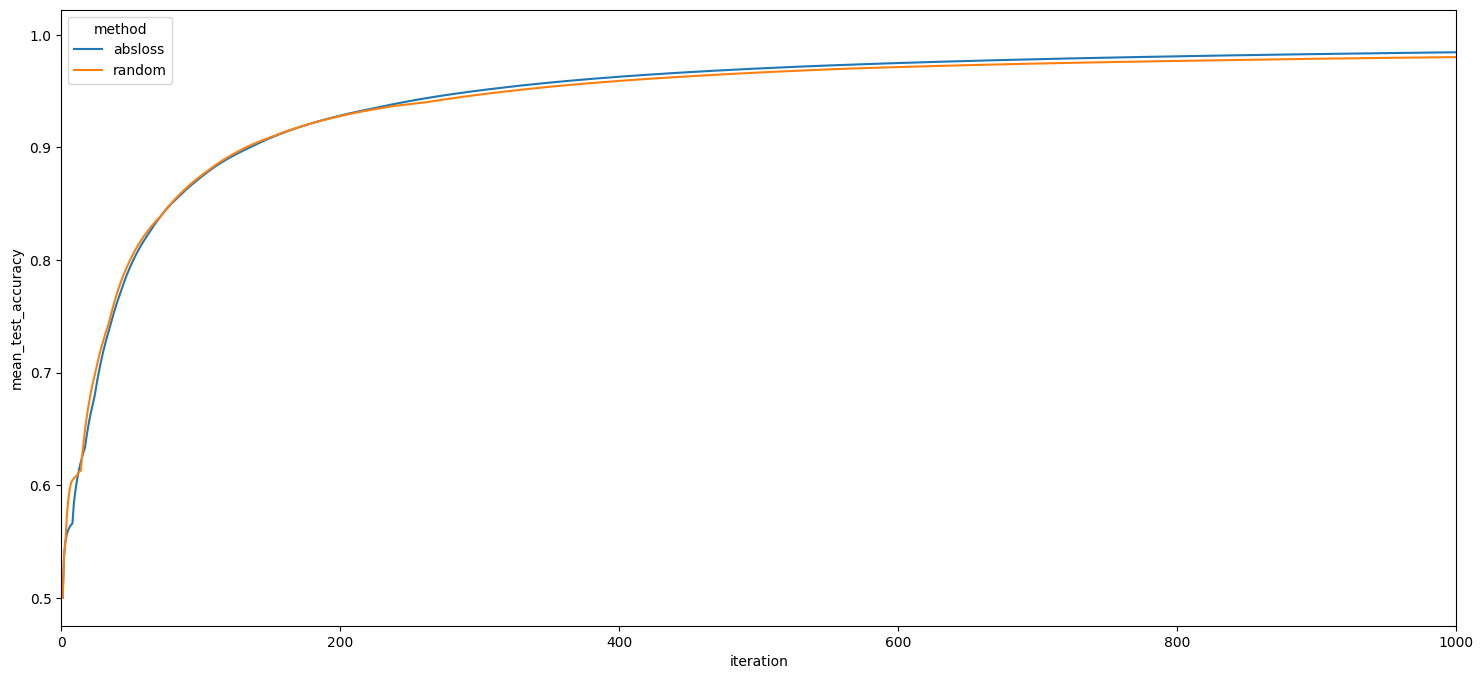

In [149]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

(0.0, 1000.0)

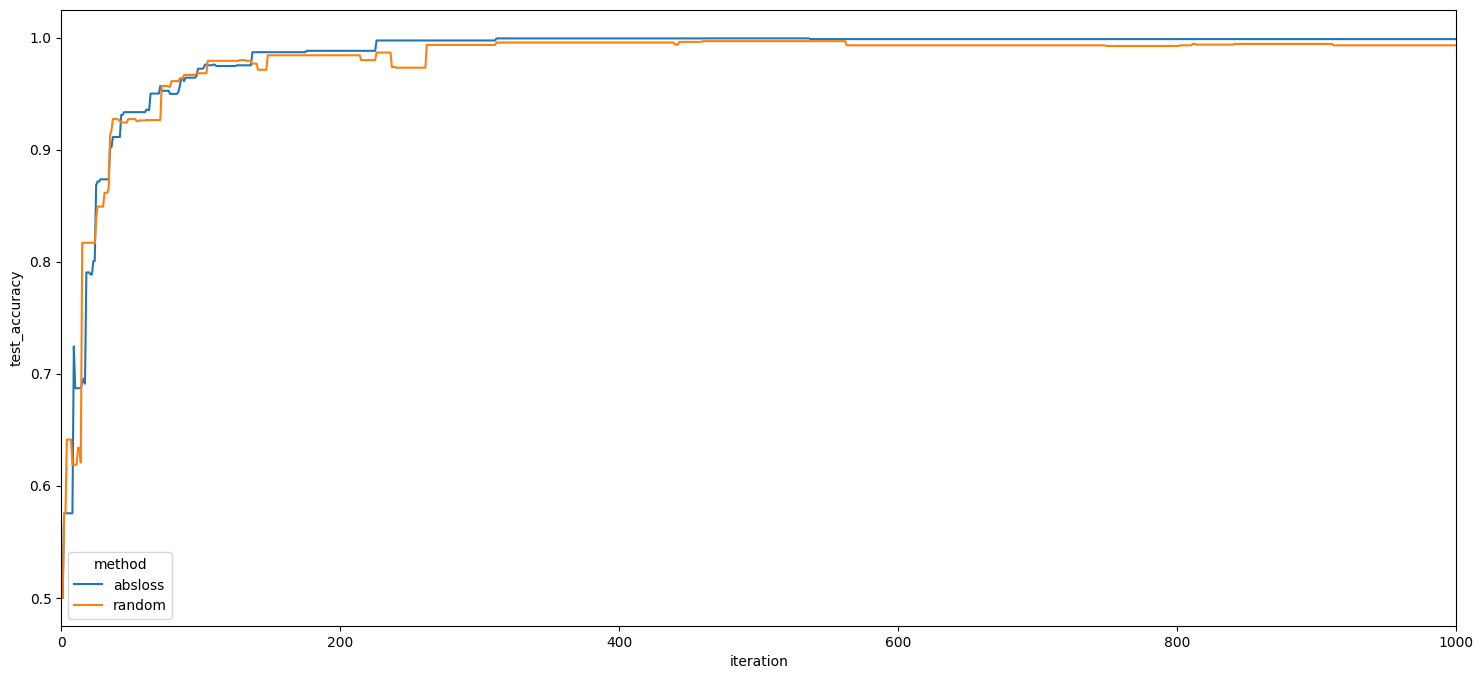

In [150]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

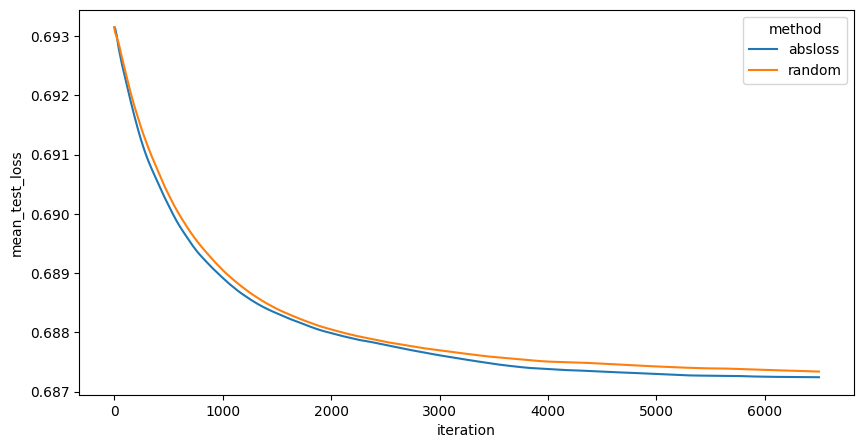

In [244]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

Text(0, 0.5, 'average cross entropy loss')

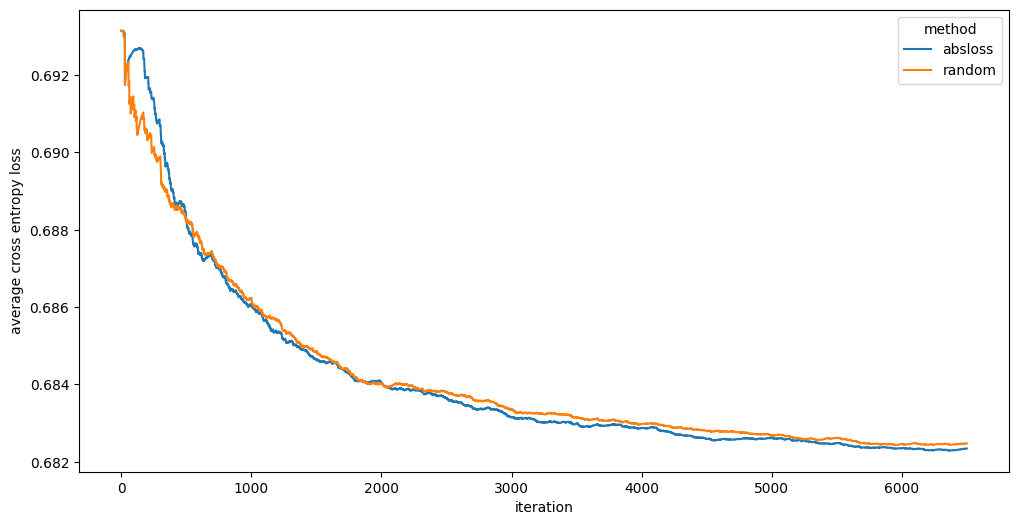

In [275]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [202]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6894892521187528, train loss: 0.6909426079636423, ||theta||_1: 272.26632538040656
loss: 0.687832484577947, train loss: 0.6836845895096142, ||theta||_1: 384.3838812419812
loss: 0.6873590394381127, train loss: 0.6683499252892475, ||theta||_1: 430.30175978882346
loss: 0.6871796736916264, train loss: 0.6831300893746173, ||theta||_1: 449.2151668858651
loss: 0.686684890700022, train loss: 0.6920607893321553, ||theta||_1: 456.0075723391618
loss: 0.6867933551458597, train loss: 0.6834710435832684, ||theta||_1: 460.1935258442605
loss: 0.6869873069395158, train loss: 0.6606421971867661, ||theta||_1: 462.5263172000707
loss: 0.6868407618690772, train loss: 0.6883397622828108, ||theta||_1: 464.04208783726614
loss: 0.6865393994204636, train loss: 0.6908030913718484, ||theta||_1: 462.1910691626297
loss: 0.6868192968629725, train loss: 0.66333400060719

In [203]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.001, 0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[67.62596563116682,
 45.083977087444545,
 22.541988543722272,
 13.57162942714846,
 6.78581471357423]

In [204]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [205]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [206]:
empirical_pzs

[0.0010000000000000252,
 0.01000000000000017,
 0.10000000000000082,
 0.2500000000000013,
 0.5000000000000011]

In [207]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [210]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [211]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.min()

method           polyak_exp  probs
polyak_exponent  13.6        0.250    0.371075
                 22.5        0.100    0.163636
                 45.1        0.010    0.000013
                 6.8         0.500    0.539501
                 67.6        0.001   -0.000000
random           13.6        0.250    0.604160
                 22.5        0.100    0.602473
                 45.1        0.010    0.623682
                 6.8         0.500    0.605796
                 67.6        0.001    0.653914
Name: train_loss, dtype: float64

In [212]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs
polyak_exponent  13.6        0.250    0.659532
                 22.5        0.100    0.633676
                 45.1        0.010    0.648495
                 6.8         0.500    0.674247
                 67.6        0.001    0.681997
random           13.6        0.250    0.682784
                 22.5        0.100    0.684887
                 45.1        0.010    0.691584
                 6.8         0.500    0.682338
                 67.6        0.001    0.692757
Name: mean_train_loss, dtype: float64

Polyak exp value 67.6 has rows (12998, 15)
Polyak exp value 45.1 has rows (12998, 15)
Polyak exp value 22.5 has rows (12998, 15)
Polyak exp value 13.6 has rows (12998, 15)
Polyak exp value 6.8 has rows (12998, 15)


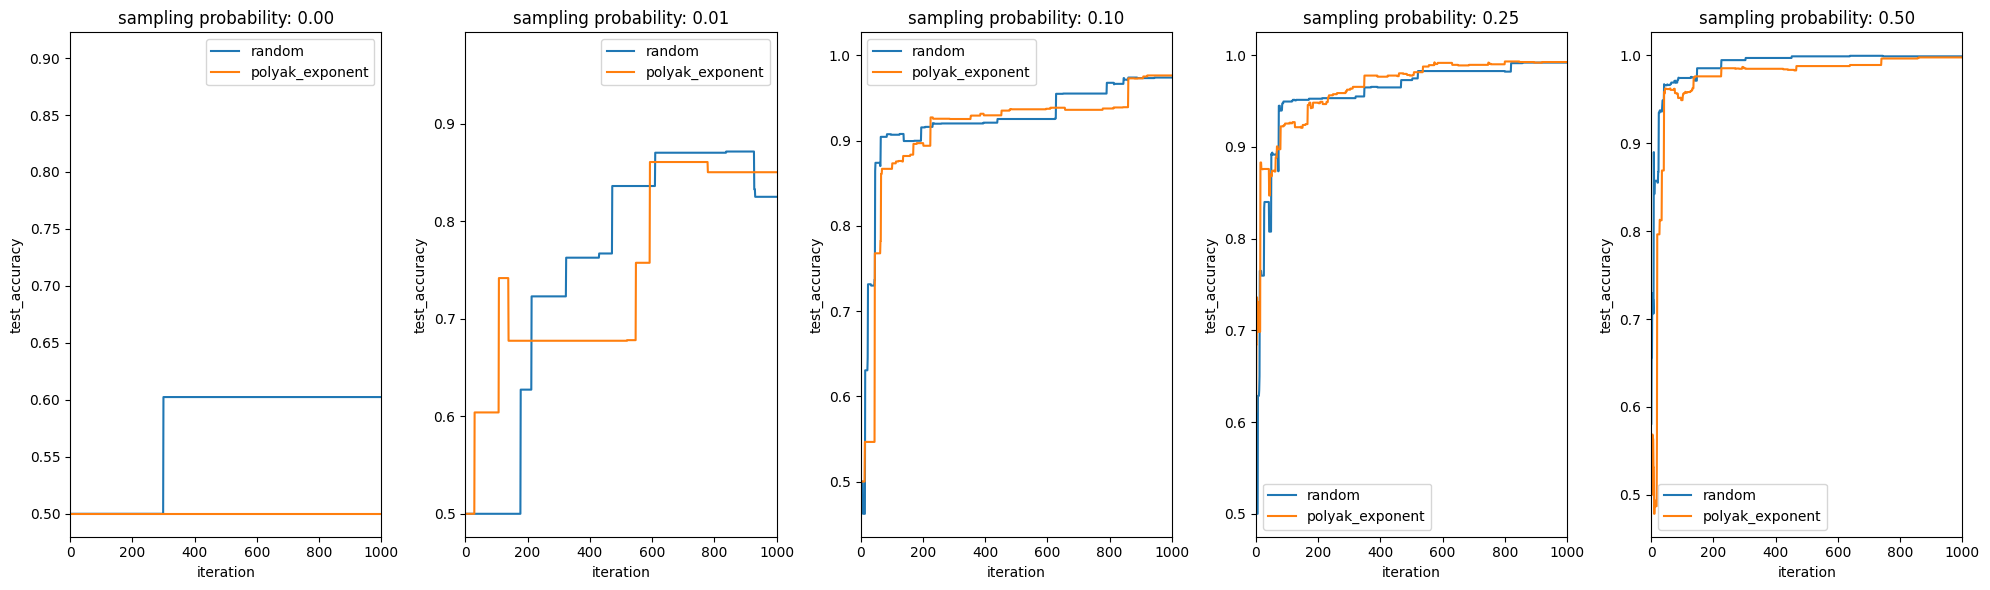

In [216]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 67.6 has rows (12998, 15)
Polyak exp value 45.1 has rows (12998, 15)
Polyak exp value 22.5 has rows (12998, 15)
Polyak exp value 13.6 has rows (12998, 15)
Polyak exp value 6.8 has rows (12998, 15)


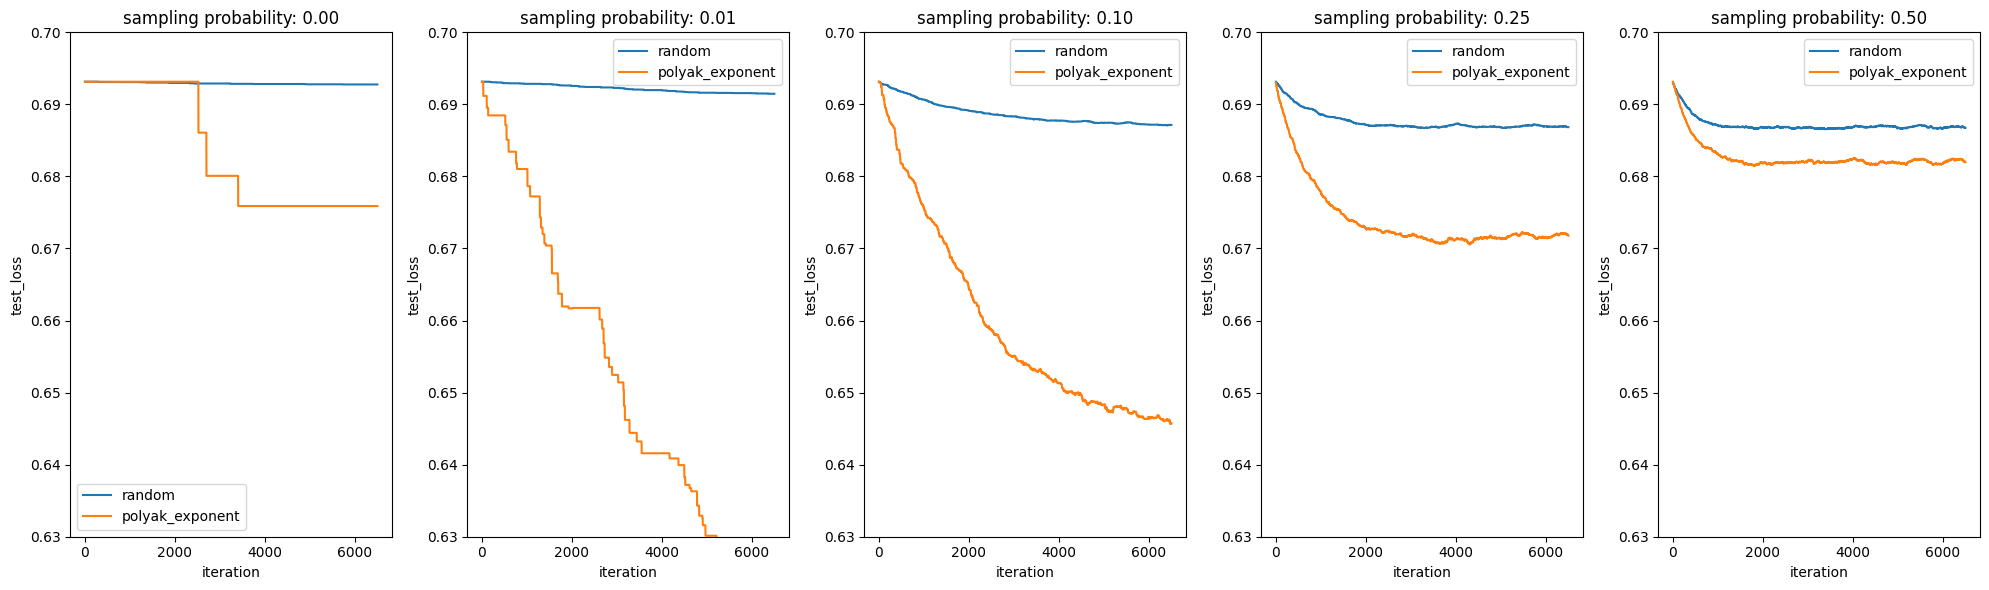

In [218]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

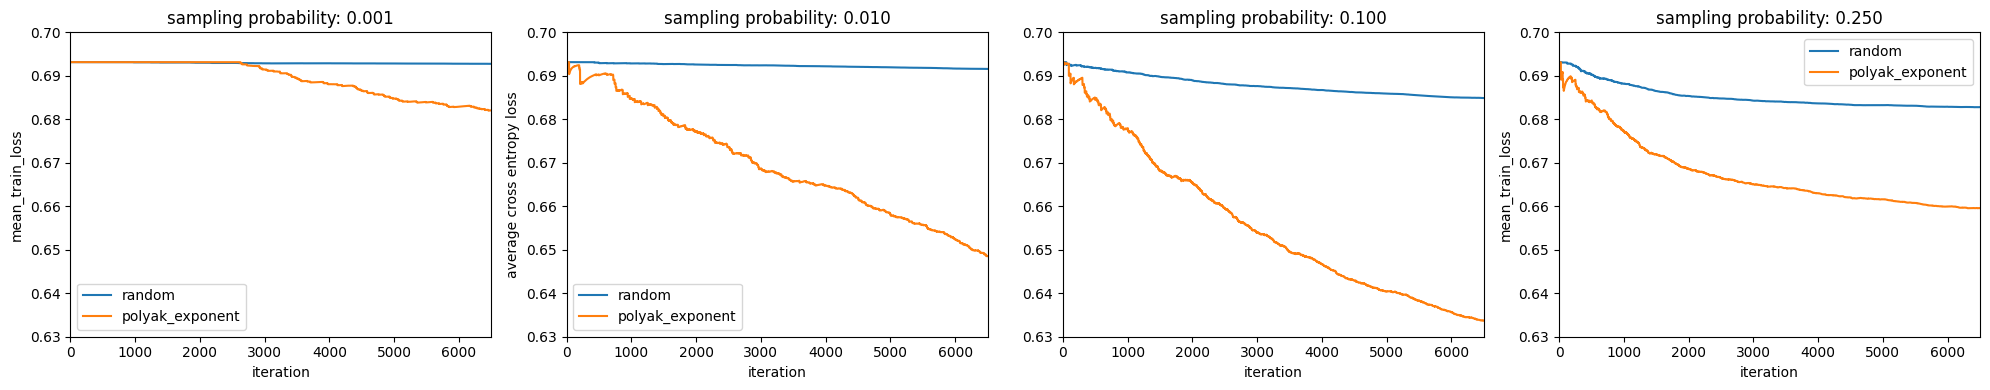

In [269]:
f, axs = plt.subplots(1, 4, figsize=(20, 4))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    if pz > 0.26:
        continue
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.63, 0.7))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[1].set_ylabel("average cross entropy loss")
axs[2].set_ylabel("")

axs[2].get_legend().remove()

f.tight_layout()

0.0010000000000000252
Polyak exp value 67.6 has rows (12998, 15)
0.01000000000000017
Polyak exp value 45.1 has rows (12998, 15)
0.10000000000000082
Polyak exp value 22.5 has rows (12998, 15)
0.2500000000000013
Polyak exp value 13.6 has rows (12998, 15)
0.5000000000000011
Polyak exp value 6.8 has rows (12998, 15)


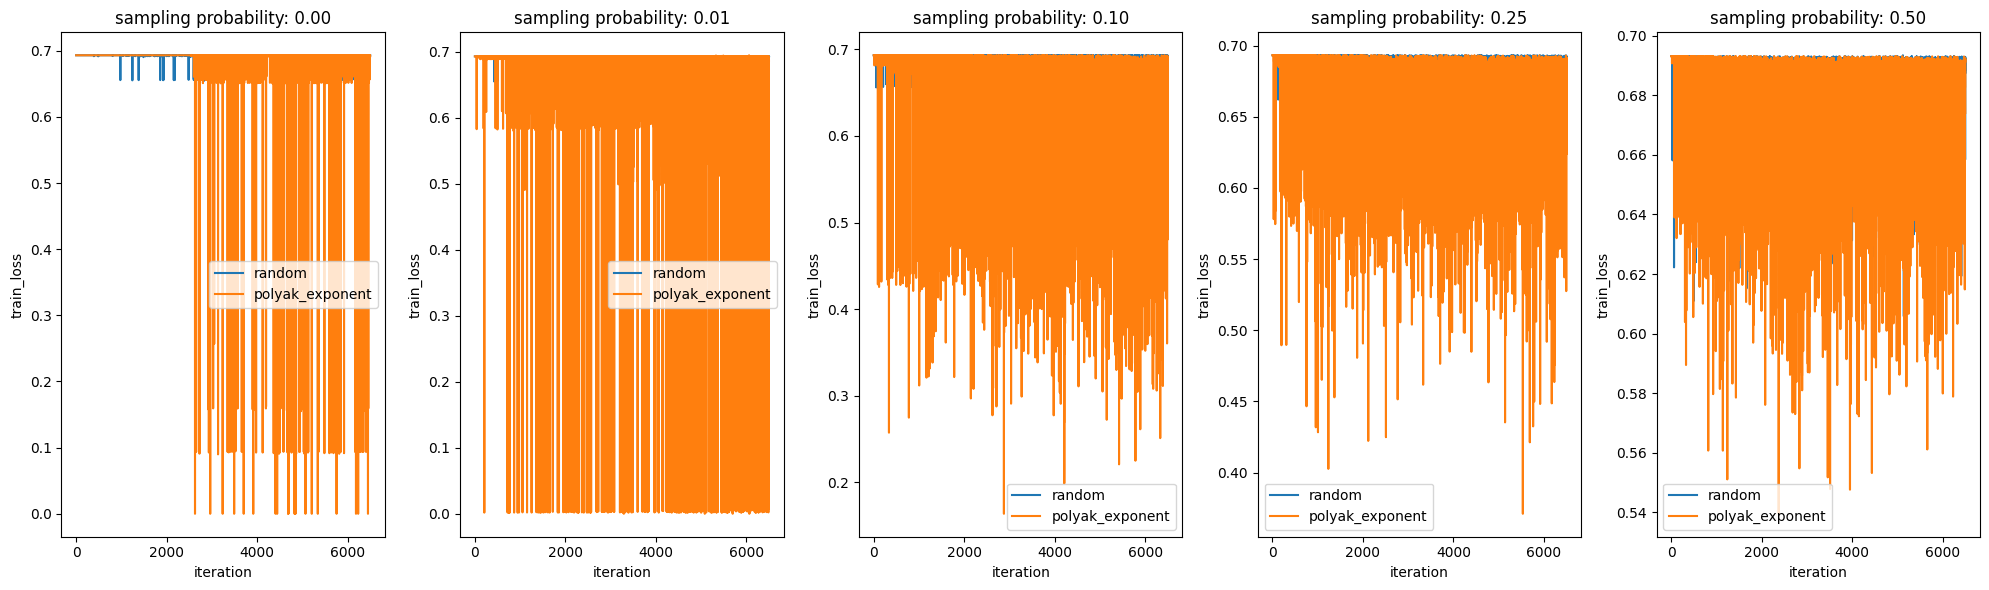

In [222]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.10000000000000082
Polyak exp value 22.5 has rows (12998, 15)
0.20000000000000107
Polyak exp value 15.8 has rows (12998, 15)
0.3000000000000013
Polyak exp value 11.8 has rows (12998, 15)
0.4000000000000013
Polyak exp value 9.0 has rows (12998, 15)
0.5000000000000011
Polyak exp value 6.8 has rows (12998, 15)
0.6000000000000013
Polyak exp value 5.0 has rows (12998, 15)
0.700000000000001
Polyak exp value 3.5 has rows (12998, 15)
0.8000000000000007
Polyak exp value 2.2 has rows (12998, 15)
0.9000000000000004
Polyak exp value 1.0 has rows (12998, 15)
1.0
Polyak exp value -0.0 has rows (12998, 15)


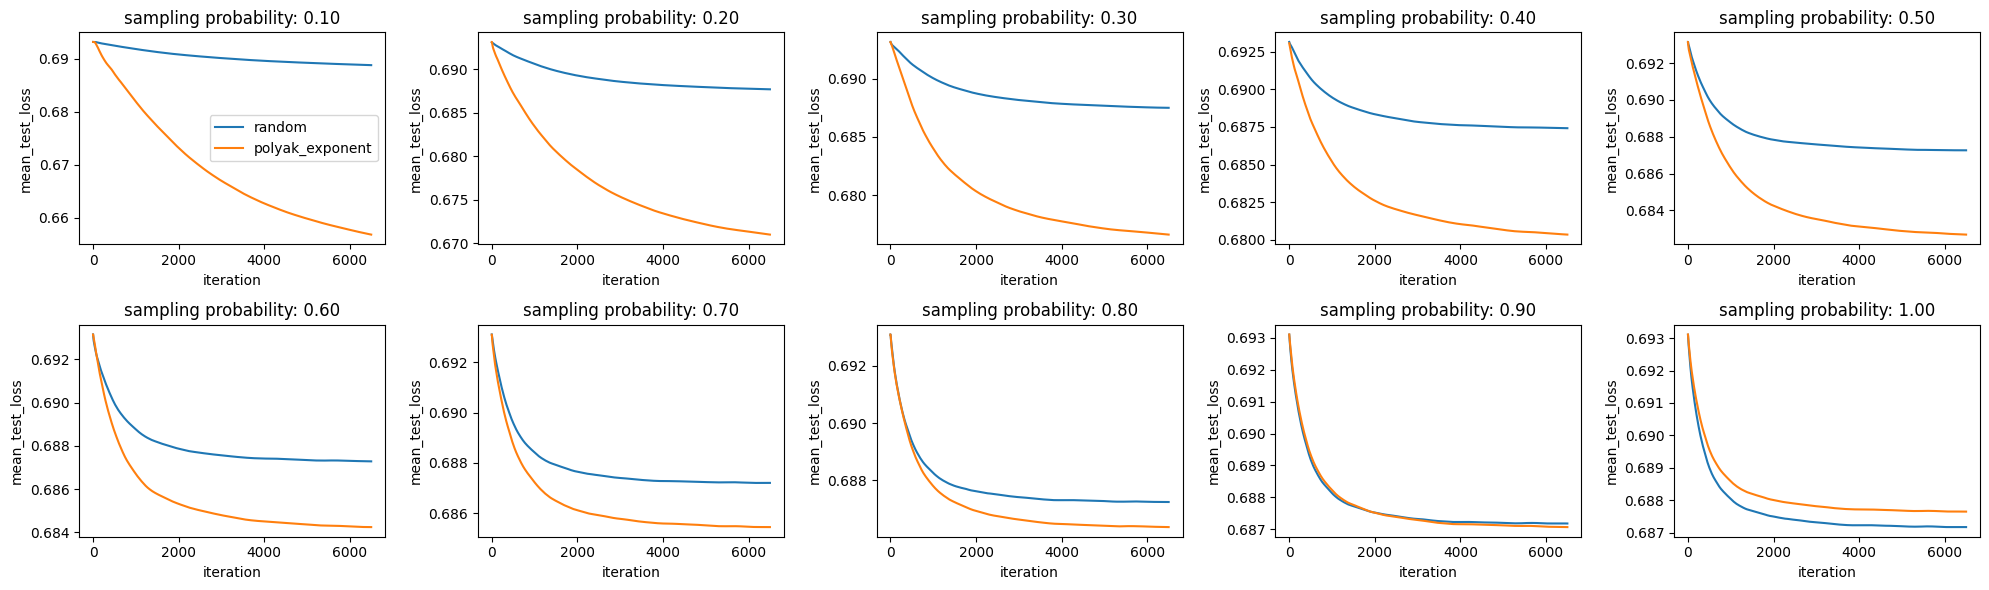

In [184]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [237]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, **(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
)

Training with algorithm polyak_absloss: 6499 iterations with d=6499
loss: 0.6930655409809918, train loss: 0.6931471805599453, ||theta||_1: 4.670414045036331
loss: 0.6883986870148242, train loss: 0.6889721808958629, ||theta||_1: 365.53507100424497
loss: 0.6852197991415193, train loss: 0.6899555512744114, ||theta||_1: 579.3997399210845
loss: 0.6837768605407682, train loss: 0.6367344114564464, ||theta||_1: 691.6500159865136
loss: 0.6833071544002697, train loss: 0.6571617550016563, ||theta||_1: 757.5177697036821
loss: 0.682363243482893, train loss: 0.6913261287514997, ||theta||_1: 800.0645918387946
loss: 0.6820180084907286, train loss: 0.6917241603109762, ||theta||_1: 823.466302194554
loss: 0.6820842511965549, train loss: 0.6307633903988216, ||theta||_1: 836.9696205082711
loss: 0.6815873349246095, train loss: 0.679783363617258, ||theta||_1: 846.307954511183
loss: 0.6811468478572141, train loss: 0.6821420105741417, ||theta||_1: 849.6834690587224
loss: 0.6816115911305703, train loss: 0.63645

In [262]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

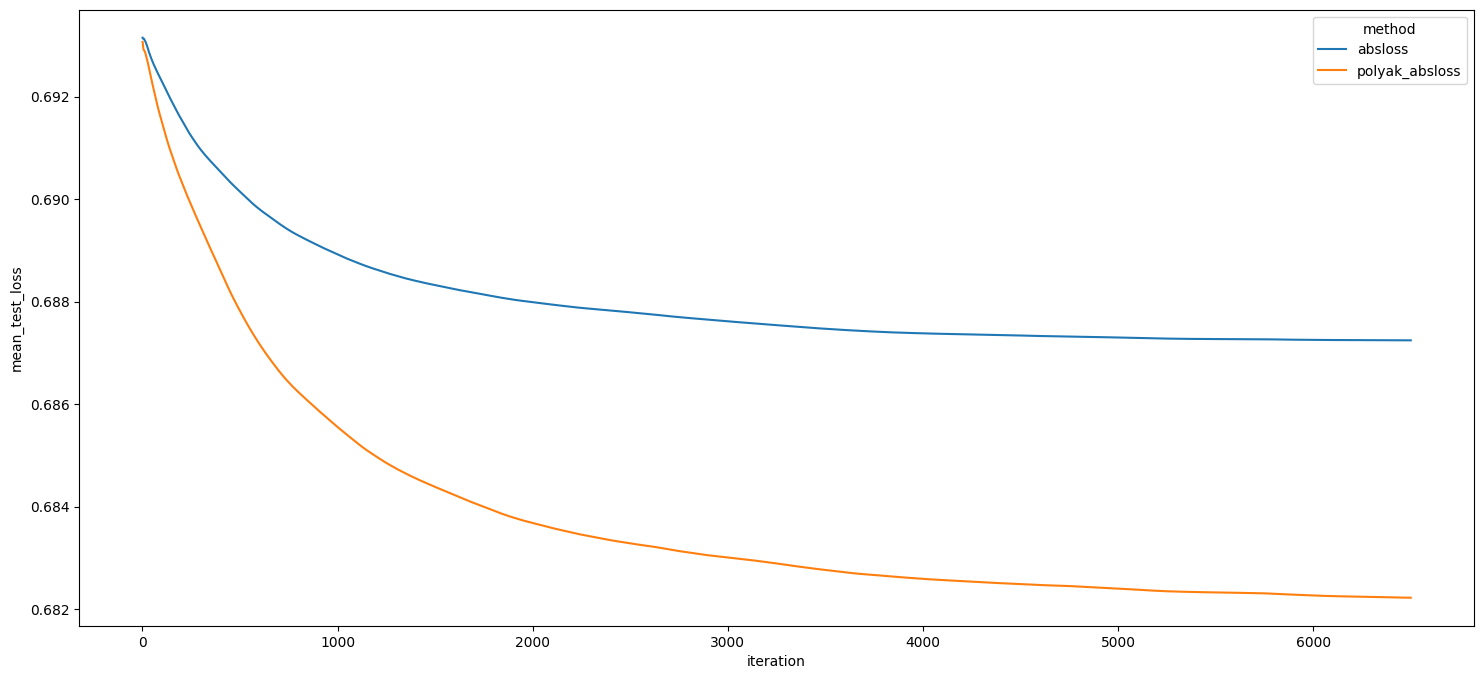

In [240]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

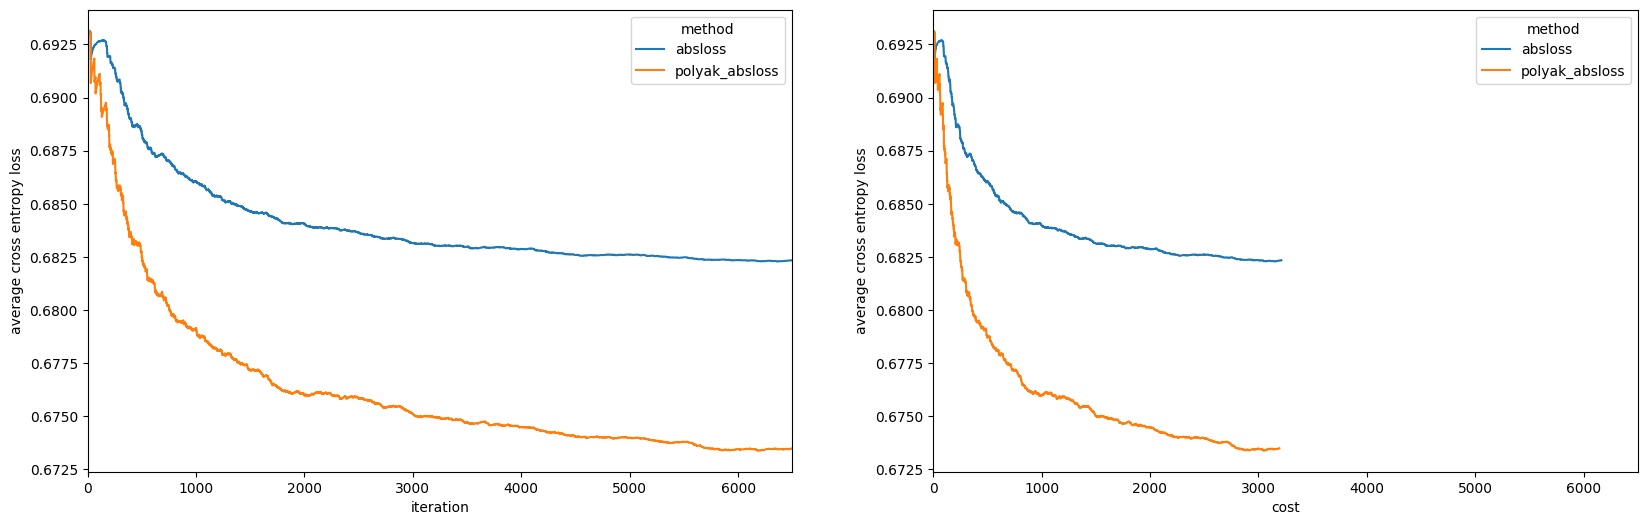

In [265]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

<Axes: xlabel='iteration', ylabel='mean_test_accuracy'>

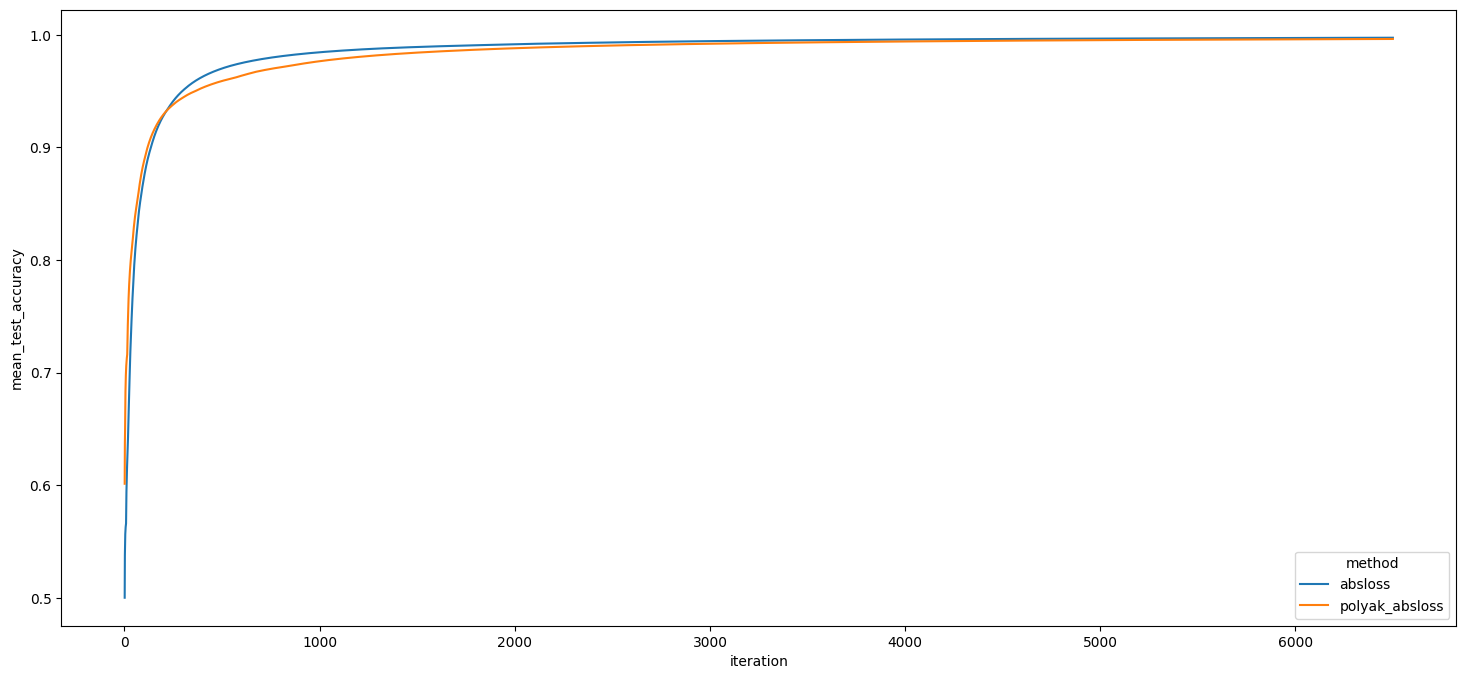

In [243]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

In [271]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss
    }
)

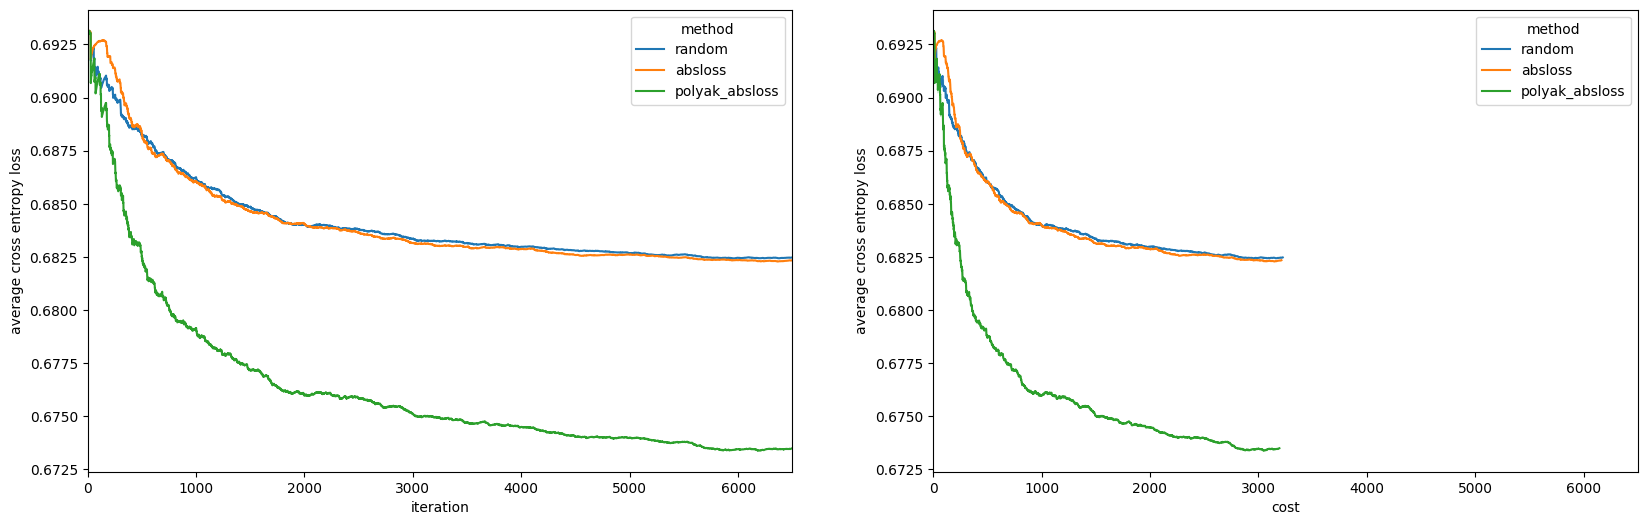

In [272]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))